In [ ]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

In [2]:
# Define file paths
CELL_TYPES_FILE = "data/consolidated_cell_types.csv.gz"
CONNECTIONS_FILE = "data/connections_princeton_no_threshold.csv.gz"

In [3]:
# Load cell types
cell_types = pd.read_csv(CELL_TYPES_FILE)

print("Cell types shape:", cell_types.shape)
cell_types.head()

Cell types shape: (137677, 3)


,root_id,primary_type,additional_type(s)
0,720575940596125868,T5c,NaN
1,720575940597856265,Tm16,NaN
2,720575940597944841,Tm7,CB3851
3,720575940598267657,TmY15,NaN
4,720575940599333574,Tm1,NaN


In [4]:
# Load connections (note: large file!)
# Using low_memory=False to avoid dtype warnings
connections = pd.read_csv(CONNECTIONS_FILE, low_memory=False)

print("Connections shape:", connections.shape)
connections.head()

Connections shape: (22285323, 5)


,pre_root_id,post_root_id,neuropil,syn_count,nt_type
0,720575940625363947,720575940623224444,ME_L,12,GABA
1,720575940613354467,720575940616690107,ME_L,1,ACH
2,720575940630432382,720575940618518557,ME_L,67,ACH
3,720575940627314521,720575940626337738,ME_L,10,GABA
4,720575940616775218,720575940632128018,ME_L,1,ACH


In [5]:
# Helpers
def partner_weights_bidirectional(
    connections: pd.DataFrame, target_id: int
) -> pd.DataFrame:
    """
    For a target neuron, return partner-wise inbound and outbound synapse weights.
    Aggregates across neuropils (sums syn_count).

    Returns columns:
      partner_id, in_w (partner→target), out_w (target→partner)
    """
    # inputs to target (pre → target)
    inp = (
        connections.loc[
            connections["post_root_id"] == target_id, ["pre_root_id", "syn_count"]
        ]
        .groupby("pre_root_id", as_index=False)["syn_count"]
        .sum()
        .rename(columns={"pre_root_id": "partner_id", "syn_count": "in_w"})
    )

    # outputs from target (target → post)
    out = (
        connections.loc[
            connections["pre_root_id"] == target_id, ["post_root_id", "syn_count"]
        ]
        .groupby("post_root_id", as_index=False)["syn_count"]
        .sum()
        .rename(columns={"post_root_id": "partner_id", "syn_count": "out_w"})
    )

    # outer-join so partners with only in_w or only out_w are included (zeros allowed)
    df = pd.merge(inp, out, on="partner_id", how="outer").fillna(
        {"in_w": 0, "out_w": 0}
    )

    return df


def attach_partner_types(df: pd.DataFrame, cell_types: pd.DataFrame) -> pd.DataFrame:
    """
    Add partner primary_type (if available)
    """
    return (
        df.merge(
            cell_types[["root_id", "primary_type"]],
            left_on="partner_id",
            right_on="root_id",
            how="left",
        )
        .drop(columns=["root_id"])
        .rename(columns={"primary_type": "partner_type"})
    )

In [ ]:
# Wedge math and plotting
import itertools
from matplotlib.cm import tab10

def reciprocity_mask(df: pd.DataFrame, wmin: int=50, angle_deg: float = 20.0) -> np.ndarray:
    """
    Return boolean mask for points inside a 'wedge' centered on the diagonal (45°)
      - in_w >= wmin and out_w > wmin
      - |atan2(in_w, out_w| <= angle_deg
    """
    x = df['out_w'].to_numpy(dtype=float)
    y = df['in_w'].to_numpy(dtype=float)

    # avoid division issues: if both zero they'll be excluded by wmin anyway
    ang = np.degrees(np.arctan2(y, x)) # 0..90 for positive quadrant
    return (x >= wmin) & (y >= wmin) & (np.abs(ang - 45.0) <= angle_deg)

def plot_reciprocity(
    df: pd.DataFrame,
    target_label: str,
    wmin: int = 50,
    angle_deg: float = 20.0,
    annotate_top: int = 12,
    label_col: str = "partner_type",
):
    """
    Scatter of in_w vs out_w with a shaded wedge around the diagonal.
    - wmin: minimum weight on both axes to be considered 'strong'
    - angle_deg: half-angle of the wedge around 45°
    - annotate_top: annotate top-N most reciprocal (by geometric mean) inside the wedge
    """
    x = df["out_w"].to_numpy()
    y = df["in_w"].to_numpy()

    fig, ax = plt.subplots(figsize=(8,6))

    # base scatter (light points)
    ax.scatter(x, y, s=8, alpha=0.25)

    # diagonal
    lim = max(x.max(), y.max()) * 1.05 if len(df) else 1
    ax.plot([0, lim], [0, lim], ls="--")

    # wedge polygon (in data coords)
    # Build wedge from two rays at 45°±angle_deg starting at (wmin, wmin)
    a1 = np.radians(45 - angle_deg)
    a2 = np.radians(45 + angle_deg)
    r = lim * 1.5
    p0 = (wmin, wmin)
    p1 = (wmin + r*np.cos(a1), wmin + r*np.sin(a1))
    p2 = (wmin + r*np.cos(a2), wmin + r*np.sin(a2))
    wedge = Polygon([p0, p1, p2], closed=True, facecolor="orange", alpha=0.15, edgecolor="none")
    ax.add_patch(wedge)

    # emphasize points inside wedge
    inside = reciprocity_mask(df, wmin=wmin, angle_deg=angle_deg)
    ax.scatter(x[inside], y[inside], s=16, alpha=0.8)

    if annotate_top and inside.any():
        gm = np.sqrt(x * y)
        idx = np.argsort(gm * inside)[-annotate_top:]
        colors = itertools.cycle(tab10.colors)

        for i, color in zip(idx, colors):
            label = str(df.iloc[i][label_col])
            ax.scatter(x[i], y[i], s=35, color=color, label=label, zorder=3)
            ax.annotate(
                label, (x[i], y[i]),
                xytext=(6, 6), textcoords="offset points",
                fontsize=8, color=color
            )

        ax.legend(fontsize=8, loc="upper left", bbox_to_anchor=(1.02, 1))

    ax.set_xlim(0, lim); ax.set_ylim(0, lim)
    ax.set_xlabel(f"synaptic weight from {target_label}")
    ax.set_ylabel(f"synaptic weight to {target_label}")
    ax.set_title(f"Reciprocity around {target_label}\n(wedge: ≥{wmin} & ±{angle_deg}° of diagonal)")
    plt.tight_layout()
    plt.show()

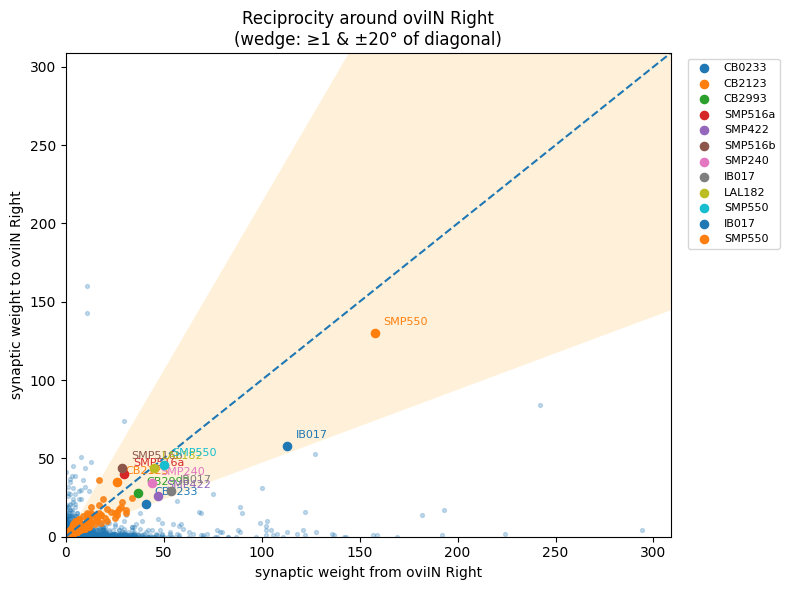

In [ ]:
# Run analysis for a neuron of interest
target_id = 720575940625741287  # e.g., oviIN Right
target_label = "oviIN Right"

df_pairs = partner_weights_bidirectional(connections, target_id)
df_pairs = attach_partner_types(df_pairs, cell_types)

# Plot; tweak wmin and angle as desired
plot_reciprocity(df_pairs, target_label, wmin=1, angle_deg=20, annotate_top=12)